
## Вступление
Линейная регрессия превосходно экстраполирует тенденции, но не может изучать взаимодействия. XGBoost отлично подходит для обучения взаимодействию, но не может экстраполировать тенденции. На этом уроке мы узнаем, как создавать «гибридные» прогнозисты, которые сочетают в себе дополнительные алгоритмы обучения и позволяют сильным сторонам одного компенсировать недостатки другого.

## Компоненты и остатки
Чтобы мы могли создавать эффективные гибриды, нам нужно лучше понимать, как строятся временные ряды. До сих пор мы изучали три модели зависимости: тренд, сезоны и циклы. Многие временные ряды могут быть точно описаны с помощью аддитивной модели, состоящей только из этих трех компонентов плюс некоторые по существу непредсказуемые, полностью случайные ошибки:

```series = trend + seasons + cycles + error```

Каждый из терминов в этой модели мы затем назвали бы компонентом временного ряда.

Ошибки модели — это разница между целью, на которой была обучена модель, и прогнозами, которые делает модель, другими словами, разница между фактической кривой и подобранной кривой. Нанесите на график ошибки по признаку, и вы получите «остаточную» часть цели или то, что модель не смогла узнать о цели из этой функции.

![](BD.png)

![](O.png)

Складываем вместе все изученные компоненты и получаем полную модель. По сути, это то, что сделала бы линейная регрессия, если бы вы обучили ее полному набору функций, моделирующих тренд, сезоны и циклы.

![](HF.png)

## Гибридное прогнозирование с остатками
В предыдущих уроках мы использовали единый алгоритм (линейную регрессию), чтобы изучить все компоненты сразу. Но также возможно использовать один алгоритм для некоторых компонентов и другой алгоритм для остальных. Таким образом, мы всегда можем выбрать лучший алгоритм для каждого компонента. Для этого мы используем один алгоритм для подбора исходного ряда, а затем второй алгоритм для подбора остаточного ряда.

Подробно процесс таков:

```
1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2

Обычно мы хотим использовать разные наборы функций (X_train_1 and X_train_2 above) в зависимости от того, чему мы хотим научиться в каждой модели. Если мы используем первую модель для изучения тренда, то, например, для второй модели нам, как правило, не понадобится функция тренда.

Хотя можно использовать более двух моделей, на практике это не кажется особенно полезным. На самом деле, наиболее распространенной стратегией построения гибридов является та, которую мы только что описали: простой (обычно линейный) алгоритм обучения, за которым следует сложный, нелинейный алгоритм обучения, такой как GBDT или глубокая нейронная сеть, простая модель, обычно разрабатываемая как «помощник» для мощного алгоритма, который следует.

## Проектирование гибридов
Помимо того, что мы описали в этом уроке, существует множество способов комбинировать модели машинного обучения. Однако для успешного объединения моделей необходимо немного глубже изучить, как работают эти алгоритмы.

Как правило, алгоритм регрессии может делать прогнозы двумя способами: либо путем преобразования признаков, либо путем преобразования цели. Алгоритмы преобразования признаков изучают некоторую математическую функцию, которая принимает признаки в качестве входных данных, а затем объединяет и преобразует их для получения выходных данных, соответствующих целевым значениям в обучающем наборе. Линейная регрессия и нейронные сети относятся к этому типу.

Алгоритмы преобразования цели используют функции для группировки целевых значений в обучающем наборе и делают прогнозы путем усреднения значений в группе; набор функций просто указывает, какую группу усреднить. Деревья решений и ближайшие соседи относятся к такому типу.

Важно следующее: преобразователи признаков обычно могут экстраполировать целевые значения за пределы обучающего набора, учитывая соответствующие признаки в качестве входных данных, но прогнозы целевых преобразователей всегда будут ограничены диапазоном обучающего набора. Если манекен времени продолжает считать временные шаги, линейная регрессия продолжает рисовать линию тренда. Учитывая тот же временной манекен, дерево решений всегда будет прогнозировать тенденцию, указанную последним шагом обучающих данных, в будущее. Деревья решений не могут экстраполировать тенденции. Случайные леса и деревья решений с градиентным усилением (например, XGBoost) представляют собой ансамбли деревьев решений, поэтому они также не могут экстраполировать тенденции.

![](j.png)

Это различие является мотивом гибридного дизайна в этом уроке: используйте линейную регрессию для экстраполяции тренда, трансформируйте цель, чтобы удалить тренд, и примените XGBoost к остаткам без тренда. Чтобы гибридизовать нейронную сеть (преобразователь признаков), вы можете вместо этого включить предсказания другой модели в качестве признака, которые нейронная сеть затем будет включать как часть своих собственных предсказаний. Метод подгонки к остаткам на самом деле является тем же методом, который использует алгоритм повышения градиента, поэтому мы будем называть эти усиленные гибриды; метод использования прогнозов в качестве функций известен как «наложение», поэтому мы будем называть эти сложенные гибриды.

## Пример — розничные продажи в США
Набор данных о розничных продажах в США содержит ежемесячные данные о продажах для различных отраслей розничной торговли с 1992 по 2019 год, собранные Бюро переписи населения США. Наша цель будет состоять в том, чтобы спрогнозировать продажи в 2016-2019 годах, учитывая продажи в предыдущие годы. Помимо создания гибрида линейной регрессии + XGBoost, мы также увидим, как настроить набор данных временных рядов для использования с XGBoost.

In [42]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

data_dir = Path("./")
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

In [43]:
retail

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677
...                      ...             ...
2019-08-01             32375           66937
2019-09-01             29963           62420
2019-10-01             32629           64849
2019-11-01             29793           66363
2019-12-01             28621           70028

[336 rows x 2 columns]

Сначала давайте воспользуемся моделью линейной регрессии, чтобы изучить тенденцию в каждом ряду. Для демонстрации мы будем использовать квадратичный (порядка 2) тренд. (Код здесь в основном такой же, как и в предыдущих уроках.) Хотя соответствие не идеальное, его будет достаточно для наших нужд.

In [44]:
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # даты из обучающих данных
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)

In [45]:
_tdf= dp.in_sample()

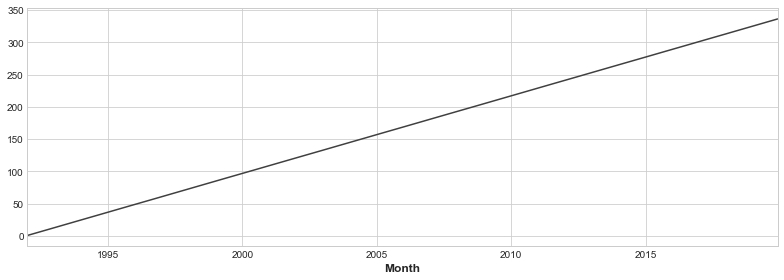

In [46]:
# Plot
axs = _tdf.trend.plot(color='0.25', subplots=True, sharex=True)


In [47]:
y

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677
...                      ...             ...
2019-08-01             32375           66937
2019-09-01             29963           62420
2019-10-01             32629           64849
2019-11-01             29793           66363
2019-12-01             28621           70028

[336 rows x 2 columns]

In [48]:
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)


LinearRegression(fit_intercept=False)

In [49]:
X_train

,const,trend,trend_squared
Month,,,
1992-01-01,1.0,1.0,1.0
1992-02-01,1.0,2.0,4.0
1992-03-01,1.0,3.0,9.0
1992-04-01,1.0,4.0,16.0
1992-05-01,1.0,5.0,25.0
...,...,...,...
2015-08-01,1.0,284.0,80656.0
2015-09-01,1.0,285.0,81225.0
2015-10-01,1.0,286.0,81796.0


In [50]:
y_train

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677
...                      ...             ...
2015-08-01             27107           57957
2015-09-01             26870           55775
2015-10-01             27667           57692
2015-11-01             26075           57099
2015-12-01             26232           62185

[288 rows x 2 columns]

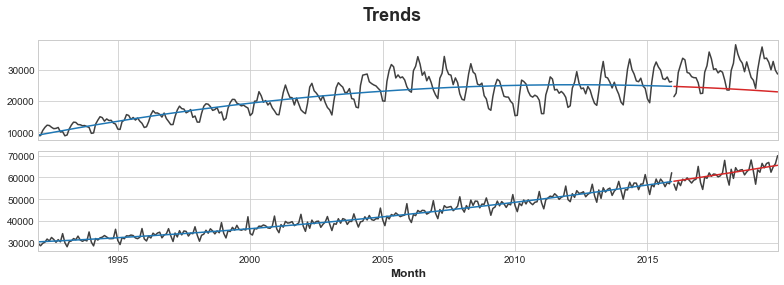

In [51]:
# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

В то время как алгоритм линейной регрессии способен к регрессии с несколькими выходами, алгоритм XGBoost — нет. Чтобы прогнозировать сразу несколько рядов с помощью XGBoost, вместо этого мы преобразуем эти ряды из широкого формата, с одним временным рядом в столбце, в длинный формат, где ряды индексируются по категориям вдоль строк.

In [52]:
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

Чтобы XGBoost научился различать два наших временных ряда, мы превратим метки строк для «Отраслей» в категориальный признак с кодировкой меток. Мы также создадим функцию годовой сезонности, вытащив номера месяцев из временного индекса.

In [53]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [54]:
X_train

,Industries,Month
Month,,
1992-01-01,0,1
1992-01-01,1,1
1992-02-01,0,2
1992-02-01,1,2
1992-03-01,0,3
...,...,...
2015-10-01,1,10
2015-11-01,0,11
2015-11-01,1,11


In [55]:
X_test

,Industries,Month
Month,,
2016-01-01,0,1
2016-01-01,1,1
2016-02-01,0,2
2016-02-01,1,2
2016-03-01,0,3
...,...,...
2019-10-01,1,10
2019-11-01,0,11
2019-11-01,1,11


In [56]:
y_train

Month       Industries       
1992-01-01  BuildingMaterials     8964
            FoodAndBeverage      29589
1992-02-01  BuildingMaterials     9023
            FoodAndBeverage      28570
1992-03-01  BuildingMaterials    10608
                                 ...  
2015-10-01  FoodAndBeverage      57692
2015-11-01  BuildingMaterials    26075
            FoodAndBeverage      57099
2015-12-01  BuildingMaterials    26232
            FoodAndBeverage      62185
Name: Sales, Length: 576, dtype: int64

Теперь мы преобразуем прогнозы тренда, сделанные ранее, в длинный формат, а затем вычтем их из исходного ряда. Это даст нам бестрендовые (остаточные) ряды, которые XGBoost сможет изучить.

In [57]:
y_fit

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01       9192.966040    30384.413252
1992-02-01       9324.354900    30430.803516
1992-03-01       9455.202650    30477.545559
1992-04-01       9585.509289    30524.639380
1992-05-01       9715.274818    30572.084979
...                      ...             ...
2015-08-01      24784.088389    57549.879292
2015-09-01      24762.343029    57695.822899
2015-10-01      24740.056559    57842.118285
2015-11-01      24717.228979    57988.765449
2015-12-01      24693.860288    58135.764391

[288 rows x 2 columns]

In [58]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set


In [59]:
y_fit

Month       Industries       
1992-01-01  BuildingMaterials     9192.966040
            FoodAndBeverage      30384.413252
1992-02-01  BuildingMaterials     9324.354900
            FoodAndBeverage      30430.803516
1992-03-01  BuildingMaterials     9455.202650
                                     ...     
2015-10-01  FoodAndBeverage      57842.118285
2015-11-01  BuildingMaterials    24717.228979
            FoodAndBeverage      57988.765449
2015-12-01  BuildingMaterials    24693.860288
            FoodAndBeverage      58135.764391
Name: Sales, Length: 576, dtype: float64

In [60]:
y_pred

Month       Industries       
2016-01-01  BuildingMaterials    24669.950487
            FoodAndBeverage      58283.115113
2016-02-01  BuildingMaterials    24645.499575
            FoodAndBeverage      58430.817613
2016-03-01  BuildingMaterials    24620.507554
                                     ...     
2019-10-01  FoodAndBeverage      65277.988422
2019-11-01  BuildingMaterials    22985.159382
            FoodAndBeverage      65441.520959
2019-12-01  BuildingMaterials    22935.817396
            FoodAndBeverage      65605.405275
Name: Sales, Length: 96, dtype: float64

In [61]:

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

[05:40:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Соответствие выглядит довольно хорошим, хотя мы можем видеть, что тренд, полученный XGBoost, настолько же хорош, как и тренд, полученный с помощью линейной регрессии — в частности, XGBoost не смог компенсировать неудовлетворительный тренд в «BuildingMaterials». ряд.

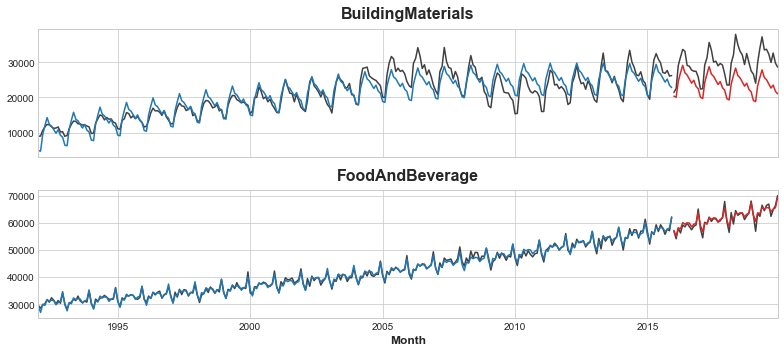

In [62]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])